In [1]:
import numpy as np
from skimage.transform import resize
from skimage import color
import matplotlib.pyplot as plt
import IPython

%load_ext autoreload
%autoreload 2
%matplotlib inline

def scale_data(vol, seg, size=180):
    length = vol.shape[0]
    vol = resize(vol, (length, size, size))
    seg = resize(seg, (length, size, size), order=0, preserve_range=True, anti_aliasing=False)

    return (vol, seg)
    
def label_data(vol, seg):
    length = vol.shape[0]
    x = vol.shape[1]
    y = vol.shape[2]
    # reshape for labeling
    seg = np.reshape(seg, (length, x*y) )
    vol = np.reshape(vol, (length, x*y) )
    # label
    labeled = color.label2rgb(seg, vol, alpha=0.1, bg_label=-1)
    # shape back
    labeled = np.reshape(labeled, (length, x, y, 3) )

    return labeled

def vis_volume(volume, fig_size=6.5):
    length = volume.shape[0]
    
    # set up
    fig = plt.figure()
    fig.set_size_inches(fig_size, fig_size)
    axes = fig.add_subplot()
    hfig = display(fig, display_id=True)

    # display
    for i in range(length):
        axes.imshow(volume[i], interpolation='none', filternorm=False, resample=False)
        fig.canvas.draw()
        hfig.update(fig)
        if i != length-1:
            plt.cla()
    # clean up
    IPython.display.clear_output()

def view_patch(patch,i=0):
    plt.rcParams['image.interpolation'] = 'nearest'
    fig, axarr = plt.subplots(3,4)
    fig.set_size_inches(16, 10)
    axarr[0,0].imshow(patch.image[0][i], cmap='gray')
    axarr[0,1].imshow(patch.label[0][i], cmap='prism')
    axarr[0,2].imshow(label_data(patch.image[0],patch.label[0])[i])
    axarr[1,0].imshow(patch.affinity[0][i], cmap='gray')
    axarr[1,1].imshow(patch.affinity[1][i], cmap='gray')
    axarr[1,2].imshow(patch.affinity[2][i], cmap='gray')
    axarr[2,0].imshow(patch.get_lsd_channel(0)[i,:,:,0])
    axarr[2,1].imshow(patch.get_lsd_channel(1)[i,:,:,0])
    axarr[2,2].imshow(patch.get_lsd_channel(2)[i,:,:,0])
    axarr[2,3].imshow(patch.get_lsd_channel(3)[i], cmap='gray')
    plt.show()


def view_affinity(affinity,i=0):
    plt.rcParams['image.interpolation'] = 'nearest'
    fig, axarr = plt.subplots(1,3)
    fig.set_size_inches(24, 20)
    axarr[0].imshow(affinity[0][i], cmap='gray')
    axarr[1].imshow(affinity[1][i], cmap='gray')
    axarr[2].imshow(affinity[2][i], cmap='gray')
    plt.show()

def view_segmentation(seg,i=0, fig_size=10):
    fig = plt.figure()
    fig.set_size_inches(fig_size, fig_size)
    colored = color.label2rgb(seg[i], alpha=1, bg_label=0)
    plt.imshow(colored)
    plt.show()

In [2]:
import math

def split_int(i, bias='left'):
    f = i/2
    big = math.ceil(f)
    sm = math.floor(f)
    if bias == 'left':
        return (big, sm)
    elif bias == 'right':
        return (sm, big)


In [16]:
from neutorch.dataset.utils import from_h5
from neutorch.dataset.proofread import ProofreadDataset

path = '../../data'
file = 'sample_A'

image = from_h5(f'{path}/{file}.hdf', dataset_path='volumes/raw')
true = from_h5(f'{path}/{file}.hdf', dataset_path='volumes/labels/neuron_ids')
pred = from_h5(f'../../RSUnet_900000_run/seg_{file}_pad.hdf', dataset_path='volumes/labels/neuron_ids')
aff = from_h5(f'../../RSUnet_900000_run/aff_{file}_pad.h5', dataset_path='affinity')

In [4]:
# pad, could do so we pad wth actual data is possible
def pad_2_divisible_by(vol, factor):
    vol_shape = vol.shape
    pad_width = []
    for i in range(len(factor)):
        left = vol_shape[i] % factor[i]
        if left > 0:
            add = factor[i] - left
            pad_width.append(split_int(add))
        else:
            pad_width.append((0, 0))
    padded = np.pad(vol, pad_width)
    vol_shape = padded.shape
    # check
    assert vol_shape[-1] % factor[-1] == 0 and vol_shape[-2] % factor[-2] == 0 and vol_shape[-3] % factor[-3] == 0, 'Image dimensions must be divisible by the patch size.'
    return padded



In [5]:
from time import time
from einops import rearrange

def patchify(vol, patch_size):
    ping = time()

    # patch
    _, pz, py, px = patch_size

    vol = pad_2_divisible_by(vol, patch_size)
    vol_arr = rearrange(vol, 'c (z pz) (y py) (x px) -> (z y x) c pz py px', pz=pz, py=py, px=px)
    print(f'rearrange took {round(time() - ping, 3)}')
    ping = time()
    return vol_arr, vol.shape


In [6]:
image = np.expand_dims(image, 0)
true = np.expand_dims(true, 0)
pred = np.expand_dims(pred, 0)
sp = image.shape
cords = np.mgrid[0:sp[0],0:sp[1],0:sp[2]]

In [7]:
import random
min_volume = 300
classes, counts = np.unique(pred, return_counts=True)
sort_indices = np.argsort(counts)
sort_indices = np.flip(sort_indices)
classes = classes[sort_indices]
counts = counts[sort_indices]
big_classes = []
for i, c in enumerate(counts):
    if c > min_volume:
        big_classes.append(classes[i])
classes = big_classes


In [8]:
patch_size = (1, 1, 16, 16)
cords_arr, padded_shape = patchify(cords, patch_size)
image_arr, padded_shape = patchify(image, patch_size)
pred_arr, padded_shape = patchify(pred, patch_size)
true_arr, padded_shape = patchify(true, patch_size)


rearrange took 16.641
rearrange took 1.216
rearrange took 3.625
rearrange took 5.27


In [9]:
c = classes[0]
print(c)
arr_indc = np.any(pred_arr == c, axis=(1,2,3,4))
print(arr_indc.shape)
print(len(pred_arr[arr_indc]))


10
(780125,)
18670


In [10]:
_, dz, dy, dx = [pad//p for p,pad in zip(patch_size,padded_shape)]
vol_shaped_indices = rearrange(arr_indc, '(dz dy dx) -> dz dy dx', dz=dz, dy=dy, dx=dx)

In [11]:
# convert to numbers to perform expand_labels
visible_indices = np.zeros_like(vol_shaped_indices)
visible_indices[vol_shaped_indices] = 1

In [12]:
from skimage.segmentation import expand_labels
# expand labels
visible_indices_exp = expand_labels(visible_indices, distance=3)

In [13]:
# convert back to bool indexing
vol_shaped_indices_exp  = visible_indices_exp == 1

# rearrange back to array indices
arr_indc_exp = rearrange(vol_shaped_indices_exp, 'dz dy dx -> (dz dy dx)', dz=dz, dy=dy, dx=dx)

print(arr_indc_exp.shape)
print(len(pred_arr[arr_indc_exp]))

(780125,)
56759


In [39]:
from neutorch.dataset.utils import from_h5
from neutorch.dataset.proofread import ProofreadDataset

path = '../../data'
file = 'sample_C'

image = from_h5(f'{path}/{file}.hdf', dataset_path='volumes/raw')
true = from_h5(f'{path}/{file}.hdf', dataset_path='volumes/labels/neuron_ids')
pred = from_h5(f'../../RSUnet_900000_run/seg_{file}_pad.hdf', dataset_path='volumes/labels/neuron_ids')
aff = None

In [70]:
from neutorch.dataset.proofread import ProofreadDataset

pd = ProofreadDataset(image, pred, true, aff, patch_size=(1,16,16), sort=True)

pre num 10074146 3407872
10074146 3 3358049
0 3358049 35928.0
3358049 6716098 35929.0
6716098 10074147 35930.0
post num 35930.0 3358048
post num 35929.0 3358049
post num 35928.0 3358049
post num 4157 0
pre num 6818936 3407872
6818936 3 2272979
0 2272979 35931.0
2272979 4545958 35932.0
4545958 6818937 35933.0
post num 35933.0 2272978
post num 35932.0 2272979
post num 35931.0 2272979
post num 21061 0
pre num 6200919 3407872
6200919 2 3100460
0 3100460 35934.0
3100460 6200920 35935.0
post num 35935.0 3100459
post num 35934.0 3100460
post num 4314 0
pre num 6154844 3407872
6154844 2 3077422
0 3077422 35936.0
3077422 6154844 35937.0
post num 35937.0 3077422
post num 35936.0 3077422
post num 4383 0
pre num 5522282 3407872
5522282 2 2761141
0 2761141 35938.0
2761141 5522282 35939.0
post num 35939.0 2761141
post num 35938.0 2761141
post num 21249 0
pre num 3772678 3407872
3772678 2 1886339
0 1886339 35940.0
1886339 3772678 35941.0
post num 35941.0 1886339
post num 35940.0 1886339
post num 2107

In [87]:
img, crds, tru = pd[4]

35932.0


In [88]:
print(img.shape)

(29142, 1, 1, 16, 16)


In [89]:
recon = np.zeros((125+1,1250+16,1250+16))
recon_label = np.zeros((125+1,1250+16,1250+16, 3))
for j in range(img.shape[0]):
    val = img[j][0]
    sz = val.shape
    st = crds[j,:,0,0,0].astype(int)
    recon[st[0]:st[0]+sz[0],st[1]:st[1]+sz[1],st[2]:st[2]+sz[2]] = val

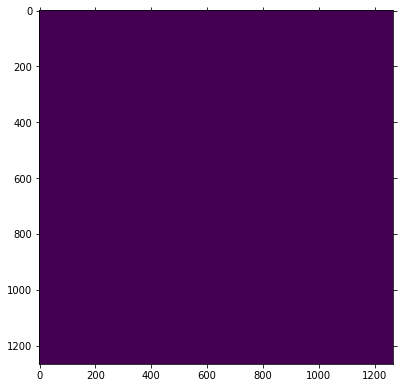

In [90]:
vis_volume(recon)


In [ ]:
import numpy as np
import random

def remap_labels(x ,start=0,end=255):
    classes = np.unique(x)
    new_classes = np.linspace(start,end,len(classes))
    for i,c in enumerate(classes):
        x[ x == c]=new_classes[i]
        
    return x

plt.rcParams['image.interpolation'] = 'nearest'
fig = plt.figure()
fig.set_size_inches(8, 8)

plt.imshow(remap_labels(label[i]), cmap='tab20')
plt.show()